In [ ]:
!pip3 install spacy
!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-2.2.5/en_core_web_lg-2.2.5.tar.gz 

     |████████████████████████████████| 827.9MB 22kB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp37-none-any.whl size=829180944 sha256=6bf8d42b8f87e6e8d381f839fadb7278e6076bdfef6dce9ae1f0feb141d1f6d6
  Stored in directory: /root/.cache/pip/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg


In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import svm
import en_core_web_lg
import tqdm
import tensorflow as tf

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
TRAIN="/content/drive/MyDrive/ML/TweetAnalysis/train.csv"

In [ ]:
TrainData = pd.read_csv(TRAIN, engine='python')
X_unp = TrainData["OriginalTweet"].to_frame()
y_unp = TrainData["Sentiment"].to_frame()
X_unp, y_unp

(                                           OriginalTweet
 0      @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
 1      advice Talk to your neighbours family to excha...
 2      Coronavirus Australia: Woolworths to give elde...
 3      My food stock is not the only one which is emp...
 4      Me, ready to go at supermarket during the #COV...
 ...                                                  ...
 41152  Airline pilots offering to stock supermarket s...
 41153  Response to complaint not provided citing COVI...
 41154  You know its getting tough when @KameronWilds...
 41155  Is it wrong that the smell of hand sanitizer i...
 41156  @TartiiCat Well new/used Rift S are going for ...
 
 [41157 rows x 1 columns],                 Sentiment
 0                 Neutral
 1                Positive
 2                Positive
 3                Positive
 4      Extremely Negative
 ...                   ...
 41152             Neutral
 41153  Extremely Negative
 41154            Positive
 41155

### Graph Plotting Function



In [ ]:
import matplotlib.pyplot as plt

def visualize_training(hist):
    plt.figure(figsize=(12,6))
    plt.plot(hist.history['accuracy'], label='training accuracy', marker='*', linewidth=3)
    plt.plot(hist.history['val_accuracy'], label='validation accuracy', marker='o', linewidth=3)
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(fontsize='large')
    plt.show()

    plt.figure(figsize=(12,6))
    plt.plot(hist.history['loss'], label='training loss', marker='*', linewidth=3)
    plt.plot(hist.history['val_loss'], label='validation loss', marker='o', linewidth=3)
    plt.title('Training Loss vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(fontsize='large')
    plt.show()



### Data Cleaning

In [ ]:
# https://medium.com/vickdata/detecting-hate-speech-in-tweets-natural-language-processing-in-python-for-beginners-4e591952223
import re
def  clean_text(df, text_field, new_text_field_name):
    # making all the text lowercase
    df[new_text_field_name] = df[text_field].str.lower()
    # remove url, special characters, 
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    # remove numbers
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))
    return df
X_clean = clean_text(X_unp, "OriginalTweet", "OriginalTweet")
X_clean.head()

,OriginalTweet
0,gahan and and
1,advice talk to your neighbours family to excha...
2,coronavirus australia woolworths to give elder...
3,my food stock is not the only one which is emp...
4,me ready to go at supermarket during the covid...


# ML Methods:

In [ ]:

X = X_clean["OriginalTweet"]
y = y_unp["Sentiment"]


In [ ]:
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)

In [ ]:
nlp = en_core_web_lg.load()
temp=[]
for x in tqdm.tqdm(X):
  temp.append(nlp(x).vector)
x_train=np.array(temp)
np.save('traindata.npy',x_train)

100%|██████████| 41157/41157 [31:58<00:00, 21.46it/s]


In [ ]:
x_train=np.load("/content/drive/MyDrive/ML/TweetAnalysis/traindata.npy")

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val= train_test_split(x_train,y,test_size=0.15, random_state = 42)
x_train.shape,y_train.shape

((34983, 300), (34983,))

### Ensemble Learning


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42).fit(x_train, y_train)
y_pred = clf.predict(x_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.40      0.43       790
           1       0.50      0.44      0.47      1005
           2       0.39      0.40      0.40      1516
           3       0.51      0.43      0.47      1176
           4       0.37      0.45      0.41      1687

    accuracy                           0.43      6174
   macro avg       0.45      0.42      0.43      6174
weighted avg       0.43      0.43      0.43      6174



### SVM

In [ ]:
svc = svm.SVC(kernel='rbf', C=1).fit(x_train, y_train)
y_pred=svc.predict(x_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.42      0.51       790
           1       0.68      0.40      0.50      1005
           2       0.44      0.51      0.47      1516
           3       0.62      0.47      0.54      1176
           4       0.42      0.61      0.50      1687

    accuracy                           0.50      6174
   macro avg       0.56      0.48      0.50      6174
weighted avg       0.54      0.50      0.50      6174



# DL Methods:

In [ ]:
earlyStop=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=1)

### RNN

In [ ]:
X = X_clean["OriginalTweet"]
y = y_unp["Sentiment"]

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)
# one hot encoding
y = tf.keras.utils.to_categorical(y)


In [ ]:
VOCAB_SIZE=1500
# Associating a number with each word
t = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE)
t.fit_on_texts(X)
X_token = t.texts_to_sequences(X)
X_token = tf.keras.preprocessing.sequence.pad_sequences(X_token)
X_token

array([[  0,   0,   0, ...,   0,   3,   3],
       [  0,   0,   0, ...,  34, 110, 238],
       [  0,   0,   0, ..., 155,   5, 138],
       ...,
       [  0,   0,   0, ...,  79,  64,  42],
       [  0,   0,   0, ...,  86,   5,   8],
       [  0,   0,   0, ...,  41,   2,  13]], dtype=int32)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=1500,
        output_dim=100),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation="softmax")
])
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         150000    
_________________________________________________________________
bidirectional_10 (Bidirectio (None, None, 200)         160800    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 100)               100400    
_________________________________________________________________
dense_10 (Dense)             (None, 25)                2525      
_________________________________________________________________
dropout_3 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 130       
Total params: 413,855
Trainable params: 413,855
Non-trainable params: 0
________________________________________________

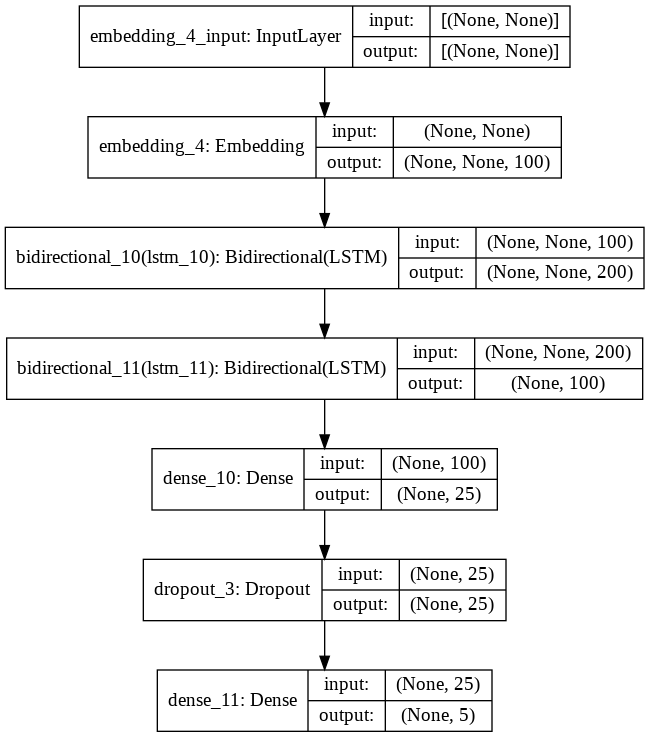

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='RNN_Model.png', show_shapes=True, show_layer_names=True)

In [ ]:
RNN = model.fit(X_token,y,epochs=15,validation_split = 0.15,callbacks=[earlyStop])


Epoch 1/15
1094/1094 [==============================] - 83s 70ms/step - loss: 1.3080 - accuracy: 0.4378 - val_loss: 1.0075 - val_accuracy: 0.6207
Epoch 2/15
1094/1094 [==============================] - 74s 68ms/step - loss: 0.9970 - accuracy: 0.6278 - val_loss: 0.9577 - val_accuracy: 0.6443
Epoch 3/15
1094/1094 [==============================] - 74s 68ms/step - loss: 0.9304 - accuracy: 0.6520 - val_loss: 0.9590 - val_accuracy: 0.6472
Epoch 4/15
1094/1094 [==============================] - 74s 68ms/step - loss: 0.8867 - accuracy: 0.6690 - val_loss: 0.9463 - val_accuracy: 0.6508
Epoch 5/15
1094/1094 [==============================] - 74s 68ms/step - loss: 0.8488 - accuracy: 0.6835 - val_loss: 0.9650 - val_accuracy: 0.6453


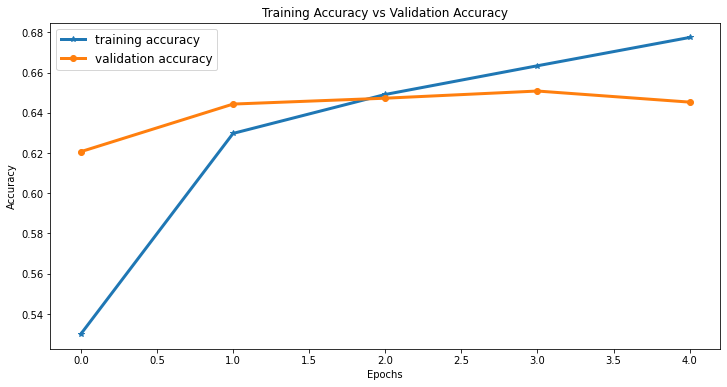

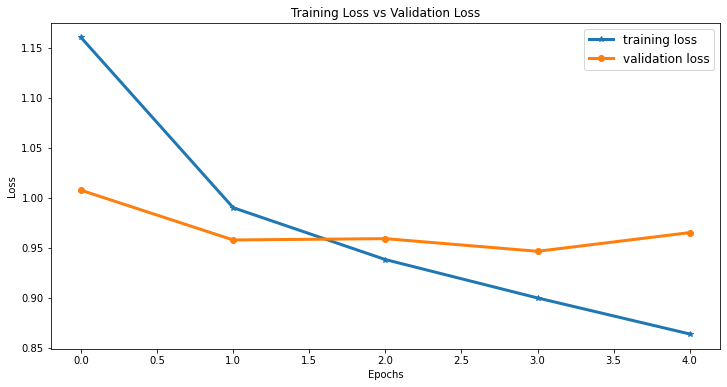

In [ ]:
visualize_training(RNN)

In [ ]:
model.save('/content/drive/MyDrive/ML/TweetAnalysis/RNN.h5')

### RNN Glove

In [ ]:
X = X_clean["OriginalTweet"]
y = y_unp["Sentiment"]

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)
#One hot encoding
y = tf.keras.utils.to_categorical(y)

In [ ]:
# Using a pretrained embedding layer
# https://keras.io/examples/nlp/pretrained_word_embeddings/
path_to_glove_file = "/content/drive/MyDrive/ML/TweetAnalysis/Glove_Files/glove.6B.100d.txt"
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
vectorizer = TextVectorization(max_tokens=2000, output_sequence_length=100)
X_ds = tf.data.Dataset.from_tensor_slices(X).batch(128)
X_ds = vectorizer.adapt(X_ds)

In [ ]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 1945 words (55 misses)


In [ ]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
)

In [ ]:
model_glove = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation="softmax")
])
model_glove.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ['accuracy'])

In [ ]:
model_glove.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         200200    
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 200)         160800    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 100)               100400    
_________________________________________________________________
dense_6 (Dense)              (None, 25)                2525      
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 130       
Total params: 464,055
Trainable params: 464,055
Non-trainable params: 0
________________________________________________

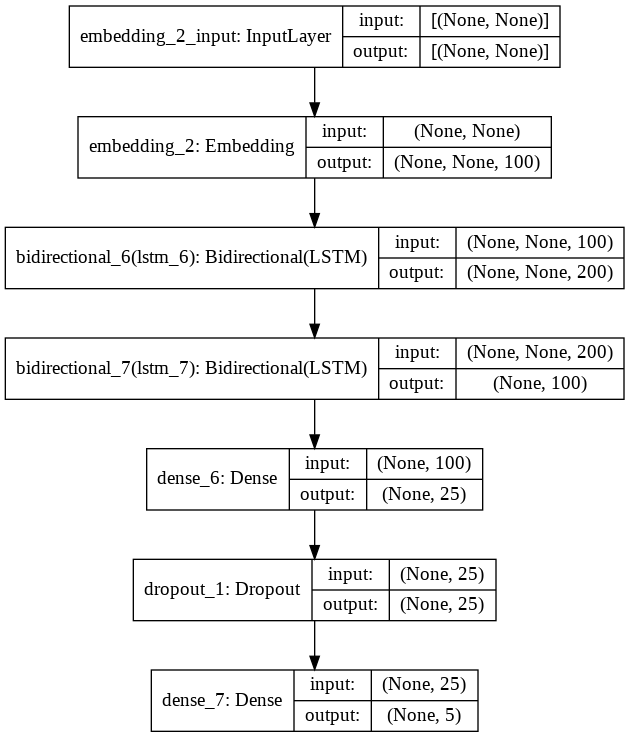

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_glove, to_file='RNN_Model.png', show_shapes=True, show_layer_names=True)

In [ ]:
X_token = vectorizer(np.array([[s] for s in X])).numpy()
X_token

array([[  1,   4,   4, ...,   0,   0,   0],
       [503, 882,   3, ...,   0,   0,   0],
       [  9, 802,   1, ...,   0,   0,   0],
       ...,
       [ 14, 128,  61, ...,   0,   0,   0],
       [ 11,  29, 729, ...,   0,   0,   0],
       [190,   1,   1, ...,   0,   0,   0]])

In [ ]:
RNN_Glove = model_glove.fit(X_token,y,epochs=15,validation_split = 0.15)

Epoch 1/15
1094/1094 [==============================] - 127s 110ms/step - loss: 1.3331 - accuracy: 0.4202 - val_loss: 0.9468 - val_accuracy: 0.6409
Epoch 2/15
1094/1094 [==============================] - 119s 108ms/step - loss: 0.9266 - accuracy: 0.6537 - val_loss: 0.8731 - val_accuracy: 0.6842
Epoch 3/15
1094/1094 [==============================] - 118s 108ms/step - loss: 0.8701 - accuracy: 0.6792 - val_loss: 0.8577 - val_accuracy: 0.6829


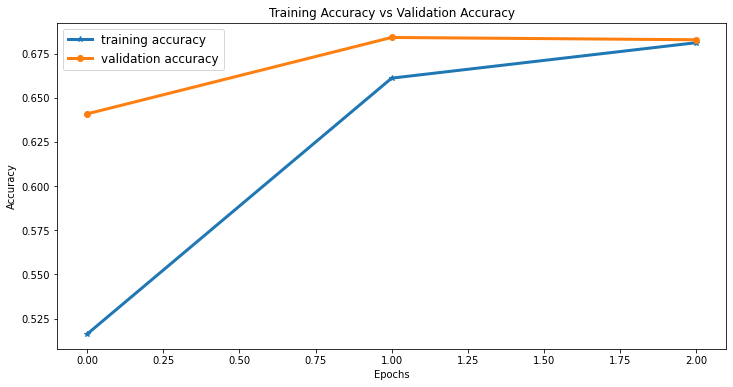

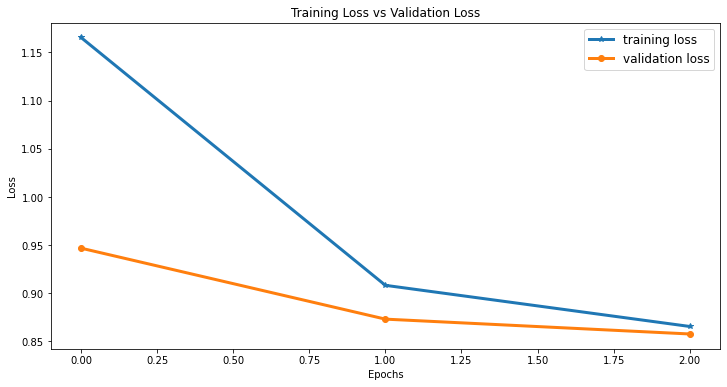

In [ ]:
visualize_training(RNN_Glove)

In [ ]:
model_glove.save('/content/drive/MyDrive/ML/TweetAnalysis/RNNGlove.h5')

### Predictions

In [ ]:
TEST = '/content/drive/MyDrive/ML/TweetAnalysis/kaggletest.csv'
TestData = pd.read_csv(TEST, engine='python')
X_test_unp = TestData["OriginalTweet"].to_frame()
X_test_unp.coloumns = "OriginalTweet"
X_test_unp

,OriginalTweet
0,TRENDING: New Yorkers encounter empty supermar...
1,When I couldn't find hand sanitizer at Fred Me...
2,Find out how you can protect yourself and love...
3,#Panic buying hits #NewYork City as anxious sh...
4,#toiletpaper #dunnypaper #coronavirus #coronav...
...,...
3793,Meanwhile In A Supermarket in Israel -- People...
3794,Did you panic buy a lot of non-perishable item...
3795,Asst Prof of Economics @cconces was on @NBCPhi...
3796,Gov need to do somethings instead of biar je r...


In [ ]:
X_clean = clean_text(X_test_unp, "OriginalTweet", "OriginalTweet")
X_clean.head()

,OriginalTweet
0,trending new yorkers encounter empty supermark...
1,when i couldnt find hand sanitizer at fred mey...
2,find out how you can protect yourself and love...
3,panic buying hits newyork city as anxious shop...
4,toiletpaper dunnypaper coronavirus coronavirus...


In [ ]:
X = X_clean['OriginalTweet']


In [ ]:
#RNN
X_token = t.texts_to_sequences(X)
X_token = tf.keras.preprocessing.sequence.pad_sequences(X_token)
X_token

array([[   0,    0,    0, ...,  332,   83,   41],
       [   0,    0,    0, ...,  892,   41,   17],
       [   0,    0,    0, ...,  712,   30,    8],
       ...,
       [   0,    0,    0, ...,   96,  719,   16],
       [   0,    0,    0, ..., 1288,  137,    5],
       [   0,    0,    0, ...,  512,    3,  176]], dtype=int32)

In [ ]:
#RNN Glove
X_token = vectorizer(np.array([[s] for s in X])).numpy()

In [ ]:
y = model_glove.predict(X_token)
y.shape

(3798, 5)

In [ ]:
ymax = np.argmax(y, axis = 1)
ymax.shape

(3798,)

In [ ]:
#converting back  to the labels
yinv = le.inverse_transform(ymax)

In [ ]:
finlist = []
finlist.append(["UserName","Sentiment"])
for i in range(0, ymax.shape[0]):
  finlist.append([i+1, yinv[i]])

In [ ]:
findf = pd.DataFrame(finlist)
findf.to_csv('/content/drive/MyDrive/ML/TweetAnalysis/ans5.csv', index=False, header=False)